# Problem Description: Image Captioning
### Objective:
The goal of this task is to develop a deep learning-based system capable of automatically generating meaningful and descriptive captions for images. The system should analyze the visual content of an image and produce a textual description that captures the objects, scenes, and actions present in the image.

### Dataset:
More than 8000 images and 5 descriptions per photo.

---

### Project: Image Captioning using Pretrained Model
### Description:
This script uses a pretrained model to generate captions for a set of test images. It extracts features using an InceptionV3 model and applies a Caption Generation Network (CGN) to generate descriptive captions.

Author: NTTrung9204.

Date: 08/01/2025.

Platform: Google Colab.



## Build class Vocab and Helper

### Vocab
The Vocab class is designed to handle vocabulary management for natural language processing tasks. It allows for the creation and indexing of a vocabulary based on word frequency thresholds, enabling efficient mapping between words and their corresponding indices.

### Helper
The Helper class provides utility functions for preprocessing and managing datasets, vocabulary building, and dataset preparation in image captioning tasks. It streamlines common operations required for training and evaluation workflows.

In [1]:
import sys
import string
import random
from keras.preprocessing.sequence import pad_sequences # type: ignore
from keras.utils import to_categorical # type: ignore
import torch
import pickle

class Vocab:
    def __init__(self, word_count_threshold: int = 10) -> None:
        self.word_count_threshold: int = word_count_threshold
        self.word_vocab: list[str] = []
        self.word_to_index: dict[str, int] = {}

    def __len__(self) -> int:
        return len(self.word_vocab) + 1


class Helper:
    def __init__(self, device: str) -> None:
        self.device = device

    def save_features_to_file(self, features: dict, file_path: str):
        with open(file_path, 'wb') as f:
            pickle.dump(features, f)
        print(f"Features saved to {file_path}")

    def load_features_from_file(self, file_path: str) -> dict:
        with open(file_path, 'rb') as f:
            features = pickle.load(f)
        print(f"Features loaded from {file_path}")
        return features

    def clean_string(self, original_string: str) -> str:
        return (
            original_string.replace("\n", "").replace(".", "").replace('"', "").strip()
        )

    def load_captions(self, pathname: str) -> dict[str, list[str]]:
        captions_dict: dict = {}
        try:
            with open(pathname, "r") as file:
                content_file: list[str] = file.readlines()
                total_lines: int = len(content_file)
                for index_line, content_line in enumerate(content_file, 1):
                    index_line: int
                    content_line: str
                    if ".jpg" in content_line:
                        content_line_split: list[str] = content_line.split(",")
                        image_name: str = content_line_split[0]
                        desciption: str = self.clean_string(
                            "".join(content_line_split[1:])
                        )
                        if image_name not in captions_dict:
                            captions_dict[image_name] = []
                        captions_dict[image_name].append(desciption)
                        sys.stdout.write(
                            f"\rLoading text file, {index_line} | {total_lines}, image name: {image_name}"
                        )
        except FileNotFoundError:
            raise Exception("File not found!")
        except Exception as e:
            raise Exception(f"Error: {e}")

        print("\nTotal captions:", len(captions_dict))

        return captions_dict

    def captions_processing(
        self, captions_dict: dict[str, list[str]]
    ) -> dict[str, list[str]]:
        new_captions_dict: dict[str, list[str]] = {}
        table: dict = str.maketrans("", "", string.punctuation)
        for image_name, captions_list in captions_dict.items():
            image_name: str
            captions_list: list[str]
            for caption in captions_list:
                caption: str
                words_list: list[str] = caption.split()
                words_list = [word.lower() for word in words_list]
                words_list = [word.translate(table) for word in words_list]
                words_list = [word for word in words_list if len(word) > 1]
                words_list = [word for word in words_list if word.isalpha()]
                caption_compile: str = " ".join(words_list)
                caption_compile = f"startseq {caption_compile} endseq"

                if image_name not in new_captions_dict:
                    new_captions_dict[image_name] = []
                new_captions_dict[image_name].append(caption_compile)

        return new_captions_dict

    def build_vocab(
        self, processed_caption: dict[str, list[str]], word_count_threshold: int = 10
    ) -> Vocab:
        word_count_dict: dict[str, int] = {}
        for _, captions_list in processed_caption.items():
            captions_list: list[str]
            for captions in captions_list:
                captions: str
                for word in captions.split():
                    word: str
                    if word not in word_count_dict:
                        word_count_dict[word] = 1
                    else:
                        word_count_dict[word] += 1

        word_index: int = 1
        word_vocab: list[str] = ['']
        word_to_index: dict[str, int] = {}
        for word, count in word_count_dict.items():
            if count >= word_count_threshold:
                word_vocab.append(word)
                word_to_index[word] = word_index
                word_index += 1

        vocab = Vocab(word_count_threshold=word_count_threshold)
        vocab.word_vocab = word_vocab
        vocab.word_to_index = word_to_index

        return vocab

    def calculate_max_length(self, data_set: dict[str, list[str]]):
        all_captions: list[str] = []
        for image_name in data_set.keys():
            [all_captions.append(caption) for caption in data_set[image_name]]
        return max(len(caption.split()) for caption in all_captions)

    def generate_dataset_structure(self, data_set: dict[str, list[str]], image_encoding: dict[str, torch.Tensor], vocab: Vocab) -> tuple[list[torch.Tensor], list[torch.Tensor], list[torch.Tensor]]:
        X1: list[torch.Tensor] = []
        X2: list[torch.Tensor] = []
        Y: list[torch.Tensor] = []
        max_length = self.calculate_max_length(data_set)
        print("Max length padding: ", max_length)
        for image_name, captions_list in data_set.items():
            image_name: str
            captions_list: list[str]
            for captions in captions_list:
                captions: str
                seq: list[str] = [vocab.word_to_index[word] for word in captions.split() if word in vocab.word_vocab]

                for index in range(1, len(seq)):
                    in_seq, out_seq = seq[:index], seq[index]

                    X1.append(torch.tensor(image_encoding[image_name]).to(self.device))
                    X2.append(torch.tensor(pad_sequences([in_seq], maxlen=max_length)[0]).to(self.device))
                    Y.append(torch.tensor(to_categorical([out_seq], num_classes=len(vocab))[0]).to(self.device))

        return X1, X2, Y

    def split_dataset(
        self, processed_caption: dict[str, list[str]], val_size: int, test_size: int
    ) -> tuple[dict[str, list[str]], dict[str, list[str]], dict[str, list[str]]]:
        image_name_list: list[str] = list(processed_caption.keys())
        random.seed(43)
        random.shuffle(image_name_list)

        val_image_name_list: list[str] = image_name_list[:val_size]
        test_image_name_list: list[str] = image_name_list[val_size : val_size + test_size]
        train_image_name_list: list[str] = image_name_list[val_size + test_size:]

        val_set: dict[str, list[str]] = {image_name: processed_caption[image_name] for image_name in val_image_name_list}
        test_set: dict[str, list[str]] = {image_name: processed_caption[image_name] for image_name in test_image_name_list}
        train_set: dict[str, list[str]] = {image_name: processed_caption[image_name] for image_name in train_image_name_list}

        return train_set, val_set, test_set


## Build SeqDataset
The SeqDataset class is a custom dataset implementation for sequence-based tasks, built to work seamlessly with PyTorch's DataLoader. It handles paired inputs (such as image features and text sequences) and their corresponding targets.

In [8]:
from torch.utils.data import Dataset
import numpy as np
import torch

class SeqDataset(Dataset):
    def __init__(self, X1: list[np.ndarray[np.float64]], X2: list[np.ndarray[np.int64]], Y: list[np.ndarray[np.int64]]) -> None:
        self.X1 = X1
        self.X2 = X2
        self.Y = Y

    def __len__(self) -> int:
        return len(self.X1)

    def __getitem__(self, index) -> tuple[tuple[np.ndarray[np.float64], np.ndarray[np.int64]], np.ndarray[np.int64]]:
        return (self.X1[index], self.X2[index]), self.Y[index]

## Build InceptionV3Model (Model for feature extracting)
The InceptionV3Model class provides functionality for feature extraction from images using the pre-trained InceptionV3 model in PyTorch. This is commonly used in transfer learning scenarios, such as image captioning, where features from images are extracted and fed into another model.

In [3]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os
import sys

class InceptionV3Model():
    def __init__(self, device: str) -> None:
        self.device = device
        self.model = self.get_feature_extractor()

    def get_feature_extractor(self) -> torch.nn.Module:
        model = models.inception_v3(pretrained=True)
        model.aux_logits = False
        model.fc = torch.nn.Identity()
        model.eval()
        return model

    def preprocess_image(self, image_path) -> torch.Tensor:
        transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        image = Image.open(image_path).convert("RGB")
        return transform(image).unsqueeze(0)

    def extract_features(self, image_list) -> dict[str, torch.Tensor]:
        features = {}
        self.model = self.model.to(self.device)
        for index, image_path in enumerate(image_list):
            image_name = os.path.basename(image_path)
            input_tensor = self.preprocess_image(image_path).to(self.device)
            with torch.no_grad():
                feature = self.model(input_tensor)
            features[image_name] = feature.squeeze().cpu().numpy()
            sys.stdout.write(f"\rExtracting image, {index} | {len(image_list)}")
        return features


## Build CaptionGenerationNet (Main model)
The CaptionGenerationNet class defines a PyTorch neural network model designed for image caption generation. This model takes image features and corresponding sequences (captions) as input and predicts the next word in the caption.

In [4]:
import torch
import torch.nn as nn

class CaptionGenerationNet(nn.Module):
    def __init__(self, vocab_size: int) -> None:
        super(CaptionGenerationNet, self).__init__()
        self.drop = nn.Dropout(0.5)
        self.fc_1 = nn.Linear(2048, 256)
        self.embedding = nn.Embedding(vocab_size, 200)
        self.lstm = nn.LSTM(200, 256, batch_first=True)
        self.fc_2 = nn.Linear(256, 256)
        self.fc_3 = nn.Linear(256, vocab_size)
        self.relu = nn.ReLU()

    def forward(self, input):
        x, y = input

        x = self.fc_1(x)
        x = self.relu(x)
        x = self.drop(x)

        y = self.embedding(y)
        y = self.drop(y)

        _, (h_n, _) = self.lstm(y)
        h_n = h_n.squeeze(0)

        z = x + h_n

        z = self.fc_2(z)
        z = self.relu(z)
        z = self.fc_3(z)

        return z

## Train Model

cuda
Loading text file, 40456 | 40456, image name: 997722733_0cb5439472.jpg
Total captions: 8091


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 167MB/s] 


Features loaded from /encoding_images_dict.pkl
Length of images encoding: 8091
Max length padding:  34
Max length padding:  26
Train set size: 377071
Val set size: 19620
Start training
Memory: 2302.80 MB
Epoch:   0, Current loss: 3.8083, Total loss: 860.4948
Epoch 1/50, Avg_Loss: 4.6513, Training Accuracy: 27.03%
Validation Accuracy: 26.54%
Epoch:   1, Current loss: 3.8690, Total loss: 683.4922
Epoch 2/50, Avg_Loss: 3.6946, Training Accuracy: 30.68%
Validation Accuracy: 29.13%
Epoch:   2, Current loss: 3.4189, Total loss: 635.1169
Epoch 3/50, Avg_Loss: 3.4331, Training Accuracy: 32.34%
Validation Accuracy: 30.86%
Epoch:   3, Current loss: 3.3235, Total loss: 608.5891
Epoch 4/50, Avg_Loss: 3.2897, Training Accuracy: 33.91%
Validation Accuracy: 31.98%
Epoch:   4, Current loss: 3.2199, Total loss: 590.2720
Epoch 5/50, Avg_Loss: 3.1907, Training Accuracy: 35.06%
Validation Accuracy: 32.42%
Epoch:   5, Current loss: 3.1911, Total loss: 576.4101
Epoch 6/50, Avg_Loss: 3.1157, Training Accurac

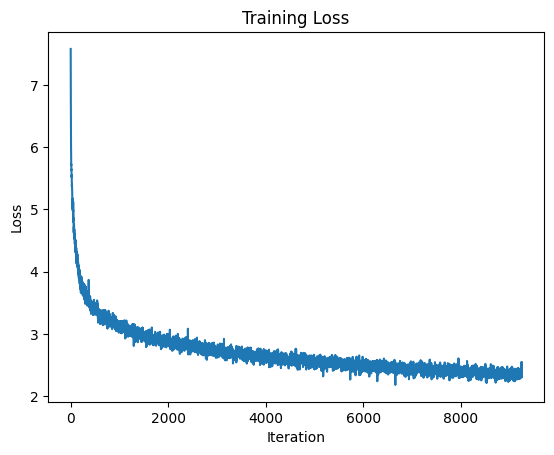

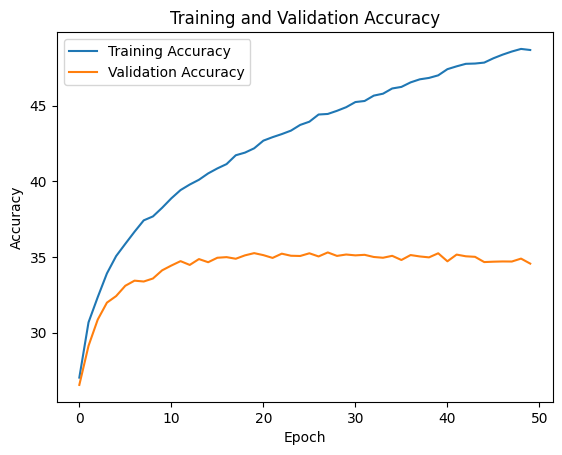

In [5]:
import torch
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
import sys
import psutil
import matplotlib.pyplot as plt

def evaluate_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, dim=1)

            total += labels.size(0)
            labels = labels.argmax(dim=1)
            correct += (predicted == labels).sum().item()

    return correct / total * 100

if __name__ == "__main__":
    process = psutil.Process()

    device = torch.device("cuda")
    print(device)

    captions_pathname = "/captions.txt"
    images_pathname = "dataset/images/"
    encoding_images_dict_path = "/encoding_images_dict.pkl"

    helper_func = Helper(device)

    captions = helper_func.load_captions(captions_pathname)

    processed_caption = helper_func.captions_processing(captions)

    vocab = helper_func.build_vocab(processed_caption, word_count_threshold=10)
    vocab_size = len(vocab)

    val_size = int(len(processed_caption) * 0.05)
    test_size = int(len(processed_caption) * 0.001)

    train_set, val_set, test_set = helper_func.split_dataset(processed_caption, val_size, test_size)

    feature_extractor_model = InceptionV3Model(device)
    model = CaptionGenerationNet(vocab_size).to(device)

    encoding_images_dict = helper_func.load_features_from_file(encoding_images_dict_path)

    print("Length of images encoding:", len(encoding_images_dict))

    x_1_train_set, x_2_train_set, y_train_set = helper_func.generate_dataset_structure(train_set, encoding_images_dict, vocab)
    x_1_val_set, x_2_val_set, y_val_set = helper_func.generate_dataset_structure(val_set, encoding_images_dict, vocab)

    print(f"Train set size: {len(x_1_train_set)}")
    print(f"Val set size: {len(x_1_val_set)}")

    train_dataset = SeqDataset(x_1_train_set, x_2_train_set, y_train_set)
    val_dataset = SeqDataset(x_1_val_set, x_2_val_set, y_val_set)

    train_set_loader = DataLoader(train_dataset, shuffle=True, batch_size=2048)
    val_set_loader = DataLoader(val_dataset, shuffle=True, batch_size=512)

    print("Start training")

    memory_usage = process.memory_info().rss
    print(f"Memory: {memory_usage / (1024 * 1024):.2f} MB")

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 50
    losses = []
    train_accuracy_list = []
    val_accuracy_list = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for images, labels in train_set_loader:
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            sys.stdout.write(f"\rEpoch: {epoch:3d}, Current loss: {losses[-1]:.4f}, Total loss: {epoch_loss:.4f}")

        avg_loss = epoch_loss / len(train_set_loader)

        train_accuracy = evaluate_accuracy(model, train_set_loader, device)
        train_accuracy_list.append(train_accuracy)

        val_accuracy = evaluate_accuracy(model, val_set_loader, device)
        val_accuracy_list.append(val_accuracy)

        print(f"\nEpoch {epoch + 1}/{num_epochs}, Avg_Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Accuracy: {val_accuracy:.2f}%")

    plt.plot(losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    plt.plot(train_accuracy_list, label='Training Accuracy')
    plt.plot(val_accuracy_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    torch.save(model, 'trained_model_v4.pth')
    torch.save(model.state_dict(), 'params_trained_model_v4.pth')

## Save Model

In [6]:
torch.save(model, '/trained_model_v4.pth')
torch.save(model.state_dict(), '/params_trained_model_v4.pth')
print("save model successfully")

save model successfully


## Test Model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading text file, 40456 | 40456, image name: 997722733_0cb5439472.jpg
Total captions: 8091


<ipython-input-7-06dcf73af5df>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("trained_model_v4.pth").to(device)


Extracting image, 0 | 1

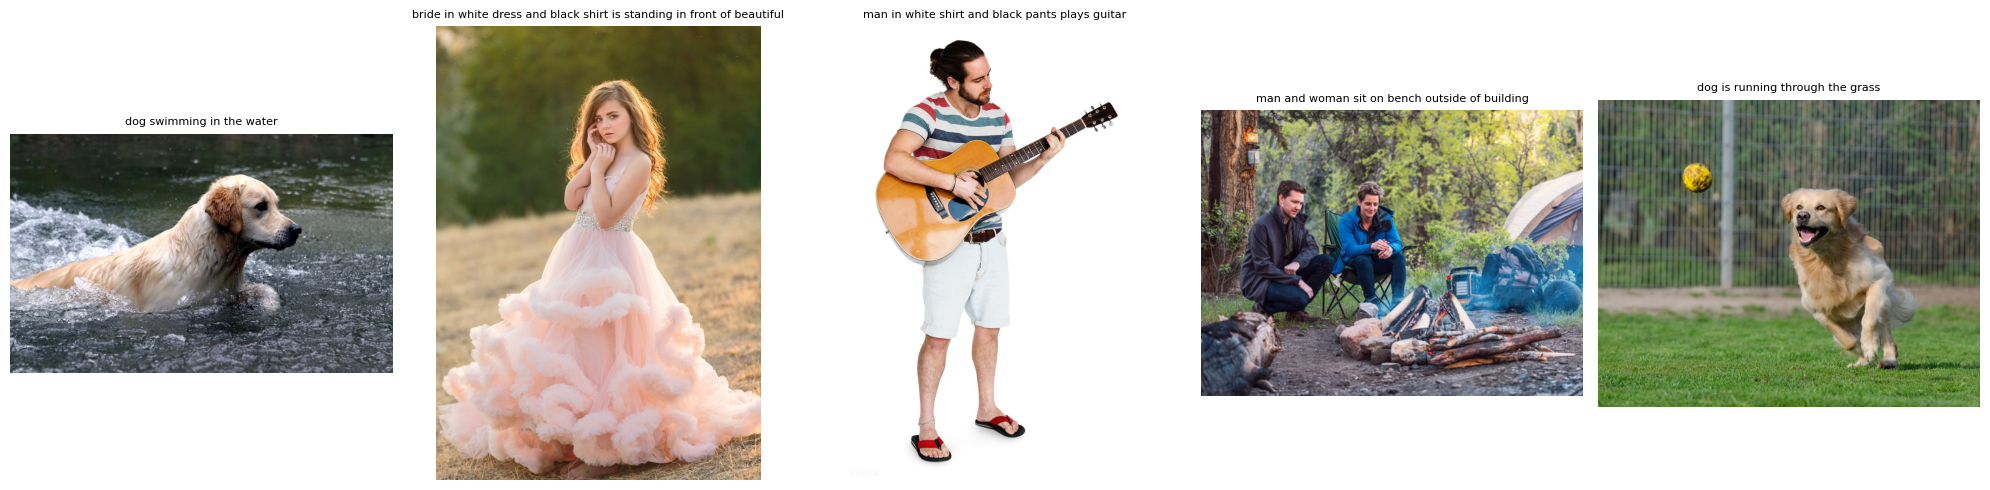

In [7]:
from keras.preprocessing.sequence import pad_sequences  # type: ignore
import torch
import matplotlib.pyplot as plt

if __name__ == "__main__":
    device = torch.device("cuda")

    helper_func = Helper(device)
    extractor = InceptionV3Model(device)

    captions_pathname = "/captions.txt"
    encoding_images_dict_path = "encoding_images_dict.pkl"

    captions = helper_func.load_captions(captions_pathname)
    processed_caption = helper_func.captions_processing(captions)
    vocab = helper_func.build_vocab(processed_caption, word_count_threshold=10)
    vocab_size = len(vocab)

    model = torch.load("trained_model_v4.pth").to(device)
    model.eval()

    max_length = helper_func.calculate_max_length(processed_caption)

    # List of test images
    image_files = [f"/test_{i}.jpg" for i in range(1, 6)]

    # Set up the plot
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    for i, image_name in enumerate(image_files):
        # Extract image features
        image_input_encoding = torch.tensor(extractor.extract_features([image_name])[image_name.split("/")[-1]]).to(device)

        # Generate caption
        input_sequences = "startseq"
        in_seq = [vocab.word_to_index[word] for word in input_sequences.split()]
        seq_input_encoding = torch.tensor(pad_sequences([in_seq], maxlen=max_length)[0]).to(device)

        while True:
            if (
                input_sequences.split()[-1] == "endseq"
                or len(input_sequences.split()) > max_length
            ):
                break

            with torch.no_grad():
                output = model((image_input_encoding, seq_input_encoding))
                next_word = vocab.word_vocab[torch.argmax(output).cpu().detach().numpy()]
                input_sequences += " " + next_word
                in_seq = [vocab.word_to_index[word] for word in input_sequences.split()]
                seq_input_encoding = torch.tensor(pad_sequences([in_seq], maxlen=max_length)[0]).to(device)

        # Clean the caption
        caption = input_sequences.replace("startseq", "").replace("endseq", "").strip()

        # Display image and caption
        image = plt.imread(image_name)
        axes[i].imshow(image)
        axes[i].set_title(caption, fontsize=8)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()
